# Lesson 2 - Exploratory Data Analysis

> A walkthrough on the fundamental mechanics to manipulate the data contained in pandas Series or DataFrame objects.

## Learning objectives

* Understand the main steps involved in exploratory data analysis
* Visualise geographical data with seaborn
* Slice, mask, and index `pandas.Series` and `pandas.DataFrame` objects
* Merge `pandas.DataFrame` objects together on a common key
* Apply the `DataFrame.groupby()` operation to aggregate data across different groups of interest

## References

This lesson draws heavily on the following textbook chapters:

* Chapter 2 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* Chapter 3 (pp. 146-170) of _Python Data Science Handbook_ by Jake Vanderplas

## Homework

* Solve the exercises included in this notebook
* Read up on [typical exploratory data analysis processes and questions](https://www.datacamp.com/community/tutorials/python-data-profiling)

If you get stuck on understanding a particular pandas technique, you might find their [docs](https://pandas.pydata.org/docs/) to be helpful.

## What is exploratory data analysis?

In data science we apply the scientific method to data with the goal to gain insights. This means that we state a hypothesis about the data, test it and refine it if necessary. In this framework, exploratory data analysis (EDA) is the step where we explore the data before actually building models. This helps us understand what information is actually contained in the data and what insights could be gained from it. 

Formally, the goals of EDA are:

- Suggest hypotheses about the phenomena of interest
- Check if necessary data is available to test these hypotheses
- Make a selection of appropriate methods and models to achieve the goal
- Suggest what data should be gathered for further investigation

This exploratory phase lays out the path for the rest of a data science project and is therefore a crucial part of the process.

## The data

In this lesson we will analyse two datasets:

* `housing.csv`
* `housing_addresses.csv`

The first is the [California housing dataset](https://www.kaggle.com/camnugent/california-housing-prices) we saw in lesson 1, while the second provides information about the neighbourhoods associated with each house. This auxiliary data was generated using the [reverse geocoding](https://en.wikipedia.org/wiki/Reverse_geocoding) functionality from [Google Maps](https://developers.google.com/maps/documentation/geocoding/intro#ReverseGeocoding), where the latitude and longitude coordinates for each house are converted into the closest, human-readable address.

The type of questions we will try to find answers to include:

* Which cities have the most houses?
* Which cities have the most expensive houses?
* What is the breakdown of the house prices by proximity to the ocean?

## Import libraries

As in lesson 1, we will be making use of the pandas and seaborn libraries. It is often a good idea to import all your libraries in a single cell block near the top of your notebooks so that your collaborators can quickly see whether they need to install new libraries or not.

In [1]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# these commands define the color scheme
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('muted'))

## Load the data

Load the files 'housing.csv' and 'housing_addresses.csv' into Colab in the same manner as in our lectures last week.

In [2]:
housing_data = pd.read_csv('housing.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing_addresses = pd.read_csv('housing_addresses.csv'); housing_addresses.head()

,street_number,route,locality-political,postal_code,latitude_longitude
0,3130,Grizzly Peak Boulevard,Berkeley,94705.0,"37.88,-122.23"
1,2005,Tunnel Road,Oakland,94611.0,"37.86,-122.22"
2,6886,Chabot Road,Oakland,94618.0,"37.85,-122.24"
3,6365,Florio Street,Oakland,94618.0,"37.85,-122.25"
4,5407,Bryant Avenue,Oakland,94618.0,"37.84,-122.25"


## Inspect the data

### The shape of data

Whenever we have a new dataset it is handy to begin by getting an idea of how large the `DataFrame` is. This can be done with either the `len` or `DataFrame.shape` methods:

In [4]:
# get number of rows
len(housing_data), len(housing_addresses)

(20640, 12590)

In [5]:
# get tuples of (n_rows, n_columns)
housing_data.shape, housing_addresses.shape

((20640, 10), (12590, 5))

### Rename columns

Usually one finds that the column headers in the raw data are either ambiguous or appear in multiple `DataFrame` objects, in which case it is handy to give them the same name. Although it's obvious from the `DataFrame.head()` method what the column headers are for our housing and address data, one often has tens or hundreds of columns and the fastest way to see their names is as follows:

In [6]:
housing_addresses.columns

Index(['street_number', 'route', 'locality-political', 'postal_code',
       'latitude_longitude'],
      dtype='object')

Let's rename the `route` and `locality-political` columns to something more transparent:

In [7]:
housing_addresses.rename(columns={'route':'street_name', 'locality-political':'city'}, inplace=True)

In [8]:
# check that the renaming worked
housing_addresses.head()

,street_number,street_name,city,postal_code,latitude_longitude
0,3130,Grizzly Peak Boulevard,Berkeley,94705.0,"37.88,-122.23"
1,2005,Tunnel Road,Oakland,94611.0,"37.86,-122.22"
2,6886,Chabot Road,Oakland,94618.0,"37.85,-122.24"
3,6365,Florio Street,Oakland,94618.0,"37.85,-122.25"
4,5407,Bryant Avenue,Oakland,94618.0,"37.84,-122.25"


> Note: Many functions like `DataFrame.rename()` can manipulate an object _in-place_ without returning a new object. In other words, when `inplace=True` is passed, the data is renamed in place as `data_frame.an_operation(inplace=True).

### Unique values

Since we are dealing with data about California, we should check that the `city` column contains a reasonable number of unique entries. In pandas we can check this the `DataFrame.nunique()` method:

In [9]:
housing_addresses['city'].nunique()

989

---

#### Exercise #1

Does the above number make sense to you? What additional data could you find to determine if it does or does not?

---

In [22]:
#we could check the geo data: lon and lat and get the unique combinations
unique_lonlat =     len(housing_addresses["latitude_longitude"].unique())
unique_postal =     len(housing_addresses['postal_code'].unique())
unique_city =       housing_addresses['city'].nunique()

print("Uniqe lon and lat:\t" , unique_lonlat)
print("Unique postal codes:\t", unique_postal)
print("\nAverage Postal/city:\t", unique_postal/unique_city)
print("Average lonlat/city:\t", unique_lonlat/unique_city)

#it seems plaussible when comparring to these datapoints. It would be normal that a city

#comparing the lon lat to the housing_data data_frame

Uniqe lon and lat:	 12590
Unique postal codes:	 1534

Average Postal/city:	 1.551061678463094
Average lonlat/city:	 12.730030333670374


## Visualising geographical data

In this lesson we will be focusing on how the house location affects its price, so let's make a scatterplot of the latitude and longitude values to see if we can identify any interesting patterns:

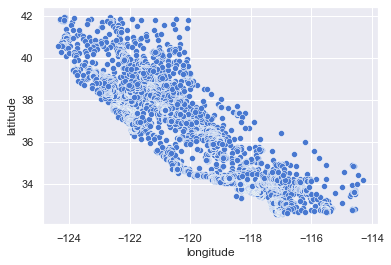

In [24]:
sns.scatterplot(x="longitude", y="latitude", data=housing_data);

Although the points look like the shape of California, we see that many are overlapping which obscures potentially interesting substructure. We can fix this by configuring the transparency of the points with the `alpha` argument:

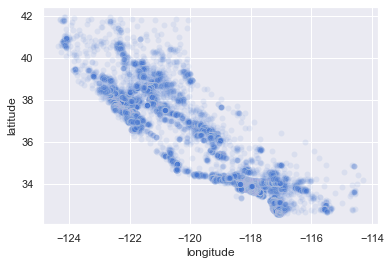

In [25]:
sns.scatterplot(x="longitude", y="latitude", data=housing_data, alpha=0.1);

This is much better as we can now see distinct clusters of houses. To make this plot even more informative, let's colour the points according to the median house value; we will use the [viridis](https://bids.github.io/colormap/) colourmap (palette) as this has been carefully designed for data that has a sequential nature (i.e. low to high values):

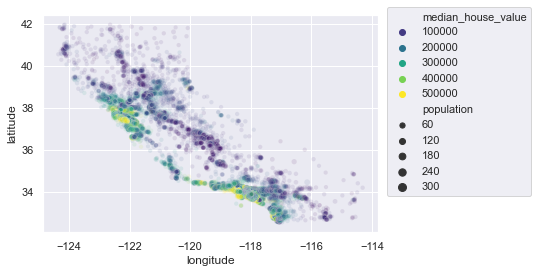

In [27]:
fig = sns.scatterplot(
    x="longitude",
    y="latitude",
    data=housing_data,
    alpha=0.1,
    hue="median_house_value",
    palette="viridis",
    size=housing_data["population"] / 100
)

# place legend outside of figure
fig.legend(loc="center left", bbox_to_anchor=(1.01, 0.6), ncol=1);

---

#### Exercise #2

What does the figure above tell us about the relationship between house prices and location or population density? 

---

 - That the denser the population the higher the house values
 - Houses in more populated areas are more in demand

---

#### Exercise #3

Can you explain the light green and yellow hotspots in the above figure?

---

## Merging DataFrames

Although the `housing_data` and `housing_addresses` `DataFrames` contain interesting information, it would be nice if there was a way to join the two tables.

More generally, one of the most common operations in pandas (or data science for that matter) is the combination of data contained in various objects. In particular, _**merge**_ or _**join**_ operations combine datasets by linking rows using one of more _**keys**_. These operations are central to relational databases (e.g. SQL-based). The `pandas.merge()` function in pandas is the main entry point for using these algorithms on your data. 

Let's use this idea to combine the `housing_data` and `housing_addresses` `pandas.DataFrame` objects via their common latitude and longitude coordinates. First we need to combine the `latitude` and `longitude` columns of `housing_data` into the same `lat,lon` format as our `housing_addresses` `pandas.DataFrame`. To do so, we will use the `Series.astype()` function to convert the numerical column values to strings, then use string concatenation to create a new `latitude_longitude` column with the desired format:

In [28]:
# create new column
housing_data['latitude_longitude'] = housing_data['latitude'].astype(str) + ',' + housing_data['longitude'].astype(str)
# check the column was created
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,latitude_longitude
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25"


--- 

#### Exercise #4

Calculate the number of unique values in the `latitude_longitude` column of both `housing_data` and `housing_addresses`.

* What can you conclude from this comparison? 
* Why do you think there might be less unique coordinate pairs than the total number of houses?

---

In [33]:
adress : int = housing_addresses['latitude_longitude'].nunique() #12590
data : int = len(housing_data["latitude_longitude"].unique())

print("Have same lenght: ", adress==data)

Have same lenght:  True


Now that we have `latitude_longitude` present in both `pandas.DataFrame` objects we can merge the two tables together in pandas as follows:

In [35]:
# create a new DataFrame from the merge
housing_merged = pd.merge(
    housing_data, housing_addresses, how="left", on="latitude_longitude"
)
# check merge worked
housing_merged.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,latitude_longitude,street_number,street_name,city,postal_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23",3130,Grizzly Peak Boulevard,Berkeley,94705.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22",2005,Tunnel Road,Oakland,94611.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24",6886,Chabot Road,Oakland,94618.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25",6365,Florio Street,Oakland,94618.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25",6365,Florio Street,Oakland,94618.0


Boom! We now have a single `pandas.DataFrame` that links information for house prices and attributes and their addresses.

> Note: The merge operation above is an example of a _**left** join_, namely we use all the key combinations of `latitude_longitude` found in the **left** table `housing_data`. 

In general the `'how'` argument of `pandas.merge()` allows four different join types:
* `'left'`: Use all key combinations found in the left table
* `'right'`: Use all key combinations found in the right table
* `'inner'`: Use only the key combinations observed in both tables
* `'outer'`: Use all key combinations observed in both tables together

A visual example of these different merges in action is shown in the figure below.

Check out [this blog post](https://towardsdatascience.com/what-is-the-difference-between-an-inner-and-an-outer-join-in-sql-5b5ec8277377) for graphical representations of the different types of joins (left, right, inner, outer join) between two DataFrames df1 and df2 that are possible in pandas.

> Warning: If the keys in one table match more than one row in the other `pandas.DataFrame` you can expect a _larger_ table to appear after you do a left join. To avoid this behaviour, you can run `DataFrame.drop_duplicates()` before doing the merge.

## Dropping columns

It is not uncommon for a dataset to have tens or hundreds of columns, and in practice we may only want to focus our attention on a smaller subset. One way to remove unwanted columns is via the `DataFrame.drop()` method. Since we have duplicate information about the latitude and longitude coordinate, we may as well drop the `latitude_longitude` column from our merged `pandas.DataFrame`:

In [36]:
# inplace=True manipulates an object without returning a new object
housing_merged.drop(['latitude_longitude'], axis=1, inplace=True); housing_merged.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,street_number,street_name,city,postal_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3130,Grizzly Peak Boulevard,Berkeley,94705.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2005,Tunnel Road,Oakland,94611.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,6886,Chabot Road,Oakland,94618.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,6365,Florio Street,Oakland,94618.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6365,Florio Street,Oakland,94618.0


> Note: You will often encounter the cryptic axis parameter when dealing with `pandas.DataFrame` and `pandas.Series` objects. This parameter is used to specify along which dimension we want to apply a given transformation. "axis=1" specifies to drop from the ‘columns’.

## Saving a DataFrame to disk

At this point, we have a unified table with housing data and their addresses. This is usually a good point to save the intermediate results to disk so that we can reload them without having to run all preprocessing steps. To do so in pandas, we can make use of the `DataFrame.to_csv()` function:

In [37]:
# use index=False to avoid adding an extra column for the index
housing_merged.to_csv('housing_merged.csv', index=False)

## Indexing, selection, and filtering

Now that we have a tidy `pandas.DataFrame` let's apply some of the most common pandas methods to make queries on the data.

### Series

A `pandas.Series` object provides array-style item selection that enables _slicing, masking,_ and _indexing_. For example, we can study the `housing_median_age` colum from a variety of angles:

In [38]:
# define a new Series object 
age = housing_merged['housing_median_age']

In [39]:
age

0        41.0
1        21.0
2        52.0
3        52.0
4        52.0
         ... 
20635    25.0
20636    18.0
20637    17.0
20638    18.0
20639    16.0
Name: housing_median_age, Length: 20640, dtype: float64

In [40]:
# get first entry
age[0]

41.0

In [41]:
# slicing by index
age[2:5]

2    52.0
3    52.0
4    52.0
Name: housing_median_age, dtype: float64

In [44]:
# slice and just get values
age[2:5].values
example = age[2:5].tolist(); print(example)

[52.0, 52.0, 52.0]


In [45]:
age.describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

In [46]:
# masking (filtering)
age[(age > 10.0) & (age < 20.0)]

75       17.0
77       19.0
80       17.0
90       16.0
131      18.0
         ... 
20632    15.0
20636    18.0
20637    17.0
20638    18.0
20639    16.0
Name: housing_median_age, Length: 4259, dtype: float64

In [47]:
# fancy indexing (i.e. passing multiple indices at once)
age[[0, 1, 4]]


0    41.0
1    21.0
4    52.0
Name: housing_median_age, dtype: float64

### DataFrame

Since a `pandas.DataFrame` acts like a two-dimensional array, pandas provides special indexing operators called `DataFrame.iloc[]` and `DataFrame.loc[]` to slice and dice our data. `loc` is based on labels, so rows and columns need to be addressed using their labels, whereas `iloc` is based on the integer position. As an example, let's select a single row and multiple columns by _**label**_:

In [48]:
housing_merged.loc[2, ['city', 'population']] # Columns 'city' and 'population' from third row selected (row index = 2)

city          Oakland
population      496.0
Name: 2, dtype: object

We can perform similar selections with _**integers**_ using `DataFrame.iloc[]`:

In [49]:
housing_merged.iloc[2, [5,11,12]]

population           496.0
street_name    Chabot Road
city               Oakland
Name: 2, dtype: object

Masks or filters are especially common to use, e.g. let's select the subset of expensive houses:

In [50]:
housing_merged.loc[housing_merged['median_house_value'] > 450000]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,street_number,street_name,city,postal_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3130,Grizzly Peak Boulevard,Berkeley,94705.0
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,NEAR BAY,321,10th Street,Oakland,94607.0
140,-122.18,37.81,30.0,292.0,38.0,126.0,52.0,6.3624,483300.0,NEAR BAY,NaN,NaN,Oakland,94611.0
459,-122.25,37.87,52.0,609.0,236.0,1349.0,250.0,1.1696,500001.0,NEAR BAY,15,Canyon Road,Berkeley,94704.0
489,-122.25,37.86,48.0,2153.0,517.0,1656.0,459.0,3.0417,489600.0,NEAR BAY,2805,Kelsey Street,Berkeley,94705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,-118.90,34.14,35.0,1503.0,263.0,576.0,216.0,5.1457,500001.0,<1H OCEAN,890,West Potrero Road,Thousand Oaks,91361.0
20426,-118.69,34.18,11.0,1177.0,138.0,415.0,119.0,10.0472,500001.0,<1H OCEAN,NaN,East Las Virgenes Canyon Road,NaN,91307.0
20427,-118.80,34.19,4.0,15572.0,2222.0,5495.0,2152.0,8.6499,500001.0,<1H OCEAN,5135,Island Forest Place,Westlake Village,91362.0
20436,-118.69,34.21,10.0,3663.0,409.0,1179.0,371.0,12.5420,500001.0,<1H OCEAN,6,Ranchero Road,Bell Canyon,91307.0


We can also use Python's string methods to filter for things like

In [59]:
housing_merged.loc[housing_merged['ocean_proximity'].str.contains('NEA')]
# select all rows in which 'ocean_proximity' attribute contains the string 'NEA'

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,street_number,street_name,city,postal_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3130,Grizzly Peak Boulevard,Berkeley,94705.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2005,Tunnel Road,Oakland,94611.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,6886,Chabot Road,Oakland,94618.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,6365,Florio Street,Oakland,94618.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6365,Florio Street,Oakland,94618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20380,-118.83,34.14,16.0,1316.0,194.0,450.0,173.0,10.1597,500001.0,NEAR OCEAN,3801,Charthouse Circle,Westlake Village,91361.0
20381,-118.83,34.14,16.0,1956.0,312.0,671.0,319.0,6.4001,321800.0,NEAR OCEAN,3801,Charthouse Circle,Westlake Village,91361.0
20423,-119.00,34.08,17.0,1822.0,438.0,578.0,291.0,5.4346,428600.0,NEAR OCEAN,NaN,Pacific View Drive,Malibu,90265.0
20424,-118.75,34.18,4.0,16704.0,2704.0,6187.0,2207.0,6.6122,357600.0,NEAR OCEAN,496,Summit Knoll Court,Oak Park,91377.0


> Note: An important feature with `pandas.Series` and `pandas.DataFrame` objects is the fact that they contain an _**index**_ that lets us slice and modify the data. This `Index` object can be accessed via `Series.index` or `DataFrame.index` and is typically an array of integers that denote the location of each row.

For example, our `age` object has an index for each row or house in the dataset:

In [163]:
age.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            20630, 20631, 20632, 20633, 20634, 20635, 20636, 20637, 20638,
            20639],
           dtype='int64', length=20640)

We can also sort the values according to the index, which in our example amounts to reversing the order:

In [60]:
age.sort_index(ascending=False)

20639    16.0
20638    18.0
20637    17.0
20636    18.0
20635    25.0
         ... 
4        52.0
3        52.0
2        52.0
1        21.0
0        41.0
Name: housing_median_age, Length: 20640, dtype: float64

Finally, there are times when you want to reset the index of the `pandas.Series` or `pandas.DataFrame` objects; this can be achieved as follows:

In [165]:
age.reset_index()

,index,housing_median_age
0,0,41.0
1,1,21.0
2,2,52.0
3,3,52.0
4,4,52.0
...,...,...
20635,20635,25.0
20636,20636,18.0
20637,20637,17.0
20638,20638,18.0


Note this creates a new `index` column and resets the order of the `pandas.Series` object in ascending order.

---

## Which cities have the most houses?

Whenever you need to quickly find the frequencies associated with categorical data, the `DataFrame.value_counts()` and `Series.nlargest()` functions come in handy. For example, if we want to see which city has the most entries in the dataframe, we can run the following:

In [61]:
housing_merged['city'].value_counts()  # For each city, this will count the number of entries for that city

Los Angeles      2372
San Diego         809
San Francisco     574
San Jose          498
Sacramento        422
                 ... 
Stevinson           1
Isleton             1
Rackerby            1
Farmington          1
Loma Rica           1
Name: city, Length: 989, dtype: int64

In [62]:
housing_merged['city'].value_counts().nlargest(10) # Prints the ten cities with the most entries

Los Angeles      2372
San Diego         809
San Francisco     574
San Jose          498
Sacramento        422
Oakland           374
Long Beach        317
Fresno            309
Stockton          242
Bakersfield       222
Name: city, dtype: int64

This seems to make sense, since Los Angeles, San Diego, and San Francisco have some of the largest populations. We can check whether this is indeed the case by *aggregating* the data to calculate the *total* population value across the *group* of cities. pandas provides a flexibly `DataFrame.groupby()` interface that enables us to slice, dice, and summarise datasets in a natural way. In particular, pandas enables us to:

* Split a pandas object into pieces using one or more keys
* Calculate group summary statistics, like count, mean, standard deviation, or a user-defined function
* Apply within-group transformations or other manipulations, like normalisation, rank, or subset selection
* Compute pivot tables and cross-tabulations.

Let's combine these ideas to answer our question, followed by an explanation of how the GroupBy mechanics really work:

In [63]:
# We start with a simple example from the pandas documentation of groupby:
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon','Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})

df.groupby(['Animal']).sum()
df.groupby(['Animal']).agg({'Max Speed':'sum'}) # does the same as the previous line

,Max Speed
Animal,
Falcon,750.0
Parrot,50.0


In [64]:
# Now we apply the previous example to our housing_merged dataset to get the total number of residence in each city by summing over all of the city's entries in the dataset:
housing_merged.groupby('city').agg({'population':'sum'}) 

,population
city,
Acampo,9626.0
Acton,6740.0
Adelanto,6583.0
Adin,364.0
Agoura Hills,26776.0
...,...
Yreka,8971.0
Yuba City,49772.0
Yucaipa,31965.0


This seems to work - we now have the total number of people residing in a city, but the result seems to be sorted alphabetically. To get the cities with the largest populations, we can use the `Series.sort_values()` method as follows:

In [170]:
housing_merged.groupby("city").agg({"population": "sum"}).sort_values(
    by="population", ascending=False
)

,population
city,
Los Angeles,3495957.0
San Diego,1069557.0
San Jose,818234.0
San Francisco,702282.0
Sacramento,614478.0
...,...
Parker,83.0
El Portal,79.0
Pearsonville,48.0


That's much better! We can store the result as a new `pandas.DataFrame` and plot the distribution:

In [65]:
# Plot populations of the 10 largest cities in descending order
top10_largest_cities = housing_merged.groupby("city").agg({"population": "sum"}).nlargest(10, columns="population").reset_index()
top10_largest_cities.head()

,city,population
0,Los Angeles,3495957.0
1,San Diego,1069557.0
2,San Jose,818234.0
3,San Francisco,702282.0
4,Sacramento,614478.0


In [66]:
# In more detail: Plot populations of the 10 largest cities in descending order
top10_largest_cities = (
    # group by key=city
    housing_merged.groupby("city")
    # calculate total population
    .agg({"population": "sum"})
    # select 10 largest
    .nlargest(10, columns="population")
    # reset index so city becomes column
    .reset_index()
)
top10_largest_cities.head()

,city,population
0,Los Angeles,3495957.0
1,San Diego,1069557.0
2,San Jose,818234.0
3,San Francisco,702282.0
4,Sacramento,614478.0


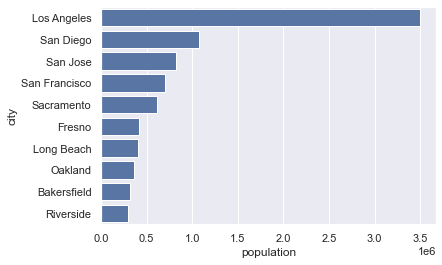

In [67]:
sns.barplot(x='population', y='city', data=top10_largest_cities, color='b');

## GroupBy mechanics

The group operation above can be best understood by the H. Wickam's [_split-apply-combine_](https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99) strategy, where you break up a big problem into manageable pieces, operate on each piece independently and then put all the pieces back together. 

**Split:**
In the first stage of the process, data contained in a `pandas.Series` or `pandas.DataFrame` object is _split_ into groups based on one or more specified _keys_. The splitting is performed on a particular _axis_ of the object. For example, a `pandas.DataFrame` can be grouped on its rows (`axis=0`) or its columns (`axis=1`).

**Apply:**
Once the split has been accomplished, a function is _applied_ to each group, producing a new value. 

**Combine:**
Finally, the results of all those function applications are _combined_ into a result object. The form of the resulting object will usually depend on what's being done to the data.

In general, the grouping key can take many forms and the keys do not have to be all of the same type. Frequently, the grouping information is found in the same `pandas.DataFrame` as the data you want to work on, so the key is usually a _column name_. For example let's create a simple `pandas.DataFrame` as follows:

In [68]:
df_foo = pd.DataFrame(
    {
        "key1": ["a", "a", "b", "b", "a"],
        "key2": ["one", "two", "one", "two", "one"],
        "data1": np.random.randn(5),
        "data2": np.random.randn(5),
    }
)
df_foo

,key1,key2,data1,data2
0,a,one,0.401634,1.056610
1,a,two,0.099236,1.427293
2,b,one,0.825173,0.141903
3,b,two,-0.337135,0.520449
4,a,one,-1.415750,-2.139792


We can then use the column names as the group keys:

In [69]:
grouped = df_foo.groupby('key1'); grouped

This `grouped` variable is now a _GroupBy_ object. It has not actually calculated anything yet except for some intermediate data about the group key `df_foo['key1']`. The main idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, we can get the mean per group as follows:

In [70]:
df_grouped = grouped.mean(); df_grouped

,data1,data2
key1,,
a,-0.304960,0.114704
b,0.244019,0.331176


---

#### Exercise #5

* Use the above `DataFrame.groupby()` techniques to find the top 10 cities which have the most expensive houses on average. Look up some of the names on the web - do the results make sense?
* Use the `DataFrame.loc[]` method to filter out the houses with the capped values of over $500,000. Repeat the same step as above. 

In [96]:
#top 10: expensice houses on average
df5_1 = housing_merged.groupby("city").agg({"median_house_value": "mean"}).nlargest(10, "median_house_value").reset_index()
df5_1

,median_house_value
city,
Bell Canyon,500001.0
Bradbury,500001.0
Calabasas,500001.0
Hidden Hills,500001.0
Hillsborough,500001.0
Los Altos Hills,500001.0
Palos Verdes Estates,500001.0
Rolling Hills,500001.0
Ross,500001.0


In [97]:
housing_merged.loc[housing_merged["median_house_value"] < 500000].groupby("city").agg({"median_house_value": "mean"}).nlargest(10, "median_house_value").reset_index()

,city,median_house_value
0,Emerald Hills,495900.000000
1,Montecito,463800.000000
2,Manhattan Beach,462200.000000
3,San Gregorio,456300.000000
4,Belvedere,441100.000000
5,Alamo,439060.000000
6,Topanga,437428.571429
7,Coto de Caza,436800.000000
8,Monte Sereno,432100.000000
9,Nicasio,430000.000000
